# PCA analysis

- TODO: [x] Regular PCA Vis.
- TODO: [ ] Guided PCA Vis.

---
- 2021-04-13 first created
    - [x] PCA visualizations (speaker/vowel/rate)
    - [x] PCA gradient plot (speaker/pc)
- 2021-04-23
    - [ ] Do Guided PCA analysis

In [1]:
%matplotlib inline
import os
import pickle
import re
import sys
from glob import glob
import itertools
import time

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Image
from sklearn.ensemble import IsolationForest
from tqdm import notebook, tqdm

src_dir = '/home/jkang/project/Articulatory-Data-Processor'
sys.path.append(src_dir)
from tools.utils import *
from tools.plots import *
from tools.postproc import *
from tools.guided_pca import GuidedPCA

rand_seed = 0
flatten = itertools.chain.from_iterable

## Settings

In [11]:
# ----- Settings
save_again = True
plot_again = True
use_mel = True

# --- Directories
data_raw_dir = 'data'
data_proc_dir = 'data_processed'
data_plot_dir = 'data_plots'
stat_dir = 'stats'
gpca_file = os.path.join(data_proc_dir, 'gpca.pkl')

data_file = os.path.join(data_proc_dir, 'data_2021-04-13.csv') # <----- UPDATE HERE

# --- Parameters
spkr_list = ['F01','F02','F03','F04','M01','M02','M03','M04']
vowel_list = ['IY1', 'IH1', 'EH1', 'AO1', 'AH1', 'AA1', 'AE1', 'UH1', 'UW1']
rate_list = ['N','F']
acous_col = ['F1', 'F2']
artic_col = ['TRx','TRz','TBx','TBz','TTx','TTz','JAWx','JAWz','ULx','ULz','LLx','LLz']
if use_mel:
    acous_col = [c + '_mel' for c in acous_col]
acous_col_norm = [re.sub('_mel', '_norm', ac) for ac in acous_col]
artic_col_norm = [ac+'_norm' for ac in artic_col]
pre_phone_poa = ['bilabial','alveolar','velar']
post_phone_poa = ['bilabial','alveolar','velar']

custom_vowels = ['IY1','IH1','EH1','AE1','AA1','UH1','UW1']
num_points = 9
vowel_mid_point = 0.5 # 0~1
corner_vowels = ['IY1', 'AE1', 'AA1', 'UW1']
vowel_label = ['i', 'ɪ', 'ɛ', 'ʌ', 'ɔ', 'ɑ', 'æ', 'ʊ', 'u']

vowel2ipa = {
    'IY1': 'i',
    'IH1': 'ɪ',
    'EH1': 'ɛ',
    'AO1': 'ʌ',
    'AH1': 'ɔ',
    'AA1': 'ɑ',
    'AE1': 'æ',
    'UH1': 'ʊ',
    'UW1': 'u',
}
num_pca = 3
num_gpca = 4
pca_col = ['PC1','PC2','PC3']
gpca_col = ['JAW','LIPS','vTNG','hTNG']

In [4]:
# Rebuild fontmanager 
import matplotlib.font_manager as font_manager
font_manager._rebuild()

In [5]:
# Prepare data
D = pd.read_csv(data_file)
D.tail(3)

,Token,FileID,Speaker,Block,Rate,Sent,Rep,Word,PreVowel,Vowel,...,JAWz_norm,ULx_norm,ULz_norm,LLx_norm,LLz_norm,PreVowelPOA,PostVowelPOA,Pronunciation,Tag,PlaceOfArticulation
138572,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,-0.062283,0.127111,0.047193,0.040988,-0.027688,velar,sp,K-AH1-M,C-V1-C,velar-tongue-bilabial
138573,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,-0.035660,0.105324,-0.037390,0.069666,0.076274,velar,sp,K-AH1-M,C-V1-C,velar-tongue-bilabial
138574,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,0.032341,0.138669,-0.149052,0.134113,0.268623,velar,sp,K-AH1-M,C-V1-C,velar-tongue-bilabial


In [14]:
# Load palate
pal_files = sorted(glob(os.path.join(data_raw_dir, '*.pkl')))
pal_all = load_palate(pal_files, spkr_list)
print("Loaded")

Loaded


In [15]:
# Load data parameters
with open(os.path.join(data_proc_dir, 'zscore.pkl'), 'rb') as pckl:
    Z = pickle.load(pckl)
with open(os.path.join(data_proc_dir, 'pca.pkl'), 'rb') as pckl:
    PC = pickle.load(pckl)
VT = pd.read_csv(os.path.join(data_proc_dir, 'vowel_targets.csv'))
GM = pd.read_csv(os.path.join(data_proc_dir, 'grand_means.csv'))
time_list = D.TimeAt.unique().tolist()
print('Loaded')

Loaded


## Gradient plot (PCA)

In [7]:
# Prepare data
lim = [-0.5, 0.5] # synthesis range
pca_col = ['PC1','PC2','PC3']
npc = len(pca_col)
nsample = 5
samples = np.linspace(lim[0], lim[1], nsample)
data = np.zeros((nsample*npc, npc))
data[nsample*0:nsample*1,0] = samples
data[nsample*1:nsample*2,1] = samples
data[nsample*2:nsample*3,2] = samples

Speaker = []
PC_col = []
SD_col = []
artic_data = np.zeros((len(spkr_list)*npc*nsample, len(artic_col)))

# Iterate over speakers
for i, which_spkr in tqdm(enumerate(spkr_list), total=len(spkr_list)):
    scaler = Scaler(which_spkr, Z)
    pca = PC[which_spkr]['pca']
    pal = pal_all[which_spkr]
    xdata = pca.inverse_transform(data)
    xdata = scaler.inverse_transform(xdata, 'artic')
    
    Speaker += [which_spkr]*npc*nsample
    PC_col += sorted(pca_col*nsample)
    SD_col += samples.tolist()*npc
    artic_data[npc*nsample*i:npc*nsample*(i+1),:] = xdata

PD = pd.DataFrame({
    'Speaker':Speaker,
    'PCA':PC_col,
    'SD':SD_col,
})
PD[artic_col] = pd.DataFrame(artic_data)
PD.head()

100%|██████████| 8/8 [00:00<00:00, 29986.09it/s]


,Speaker,PCA,SD,TRx,TRz,TBx,TBz,TTx,TTz,JAWx,JAWz,ULx,ULz,LLx,LLz
0,F01,PC1,-0.50,-49.951040,-4.426829,-35.052460,-1.194214,-17.333372,-11.766659,-5.671316,-26.221182,7.575541,4.659495,3.357276,-26.087909
1,F01,PC1,-0.25,-51.106279,-5.744287,-36.580094,-2.454732,-18.780655,-12.205074,-6.098418,-27.124316,7.754209,4.450467,3.154033,-26.803517
2,F01,PC1,0.00,-52.261519,-7.061744,-38.107728,-3.715249,-20.227938,-12.643488,-6.525520,-28.027450,7.932878,4.241440,2.950789,-27.519125
3,F01,PC1,0.25,-53.416758,-8.379202,-39.635362,-4.975767,-21.675221,-13.081903,-6.952622,-28.930585,8.111546,4.032413,2.747545,-28.234733
4,F01,PC1,0.50,-54.571997,-9.696660,-41.162996,-6.236284,-23.122504,-13.520318,-7.379723,-29.833719,8.290214,3.823386,2.544302,-28.950341


In [12]:
marker_types = ['circle', 'triangle_up', 'diamond']
colors = ['b', 'r', 'g']
ytick_lim = [-40, 20]
xtick_lim = [-80, 40]

# Visualize
if plot_again:
    sns.set_theme(style="whitegrid", rc={'font.family' : 'serif' , 'font.serif' : 'Times New Roman'})
    with sns.plotting_context(context='poster', font_scale=1):
        # Iterate over speakers
        for which_spkr in tqdm(spkr_list, total=len(spkr_list)):
            explained = PC[which_spkr]['explained_variance_ratio_']
            fig, arr = plt.subplots(1, 3, facecolor='white', figsize=(24, 6))
            # Iterate over PCs
            for i, (ax, which_pc) in enumerate(zip(arr, pca_col)):
                ax = plot_palpha(ax, pal=pal_all[which_spkr], fontsize=20)
                lines = []
                # Iterate over SD
                for j, which_sd in enumerate(samples):
                    # Plot
                    ax = plot_artic(ax,
                                    PD.loc[(PD.Speaker == which_spkr) & (PD.PCA == which_pc) & (PD.SD == which_sd),
                                           artic_col].values,
                                    tongue_idx=[0, 1, 2, 3, 4, 5], jaw_idx=[6, 7], lip_idx=[8, 9, 10, 11],
                                    tongue_spline=True, markersize=(j+3)*1.3,
                                    override_color=[colors[i]]*3,
                                    markerfacecolor='none')
                    lines += [ax.get_lines()[-1]]
                ax.legend(lines, samples, fontsize='small')
                # Prettify
                ax.set_title(f'{which_pc} ({explained[i]*100:.1f}% explained)', fontsize=25)
                xticks = np.linspace(xtick_lim[0], xtick_lim[1], 7)
                ax.set_xticks([t for t in xticks])
                ax.set_xticklabels([f'{t:.0f}' for t in xticks])
                yticks = np.linspace(ytick_lim[0], ytick_lim[1], 7)
                ax.set_yticks([t for t in yticks])
                ax.set_yticklabels([f'{t:.0f}' for t in yticks])
            fig.suptitle(f'{which_spkr}', fontsize=35, y=0.9)
            fig.tight_layout()
            fig.savefig(os.path.join(data_plot_dir, which_spkr, f'{which_spkr}_pca_gradient.png'), bbox_inches='tight')
            plt.close()
    print('Saved')
else:
    print('Skipping')

100%|██████████| 8/8 [00:04<00:00,  1.87it/s]

Saved


interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

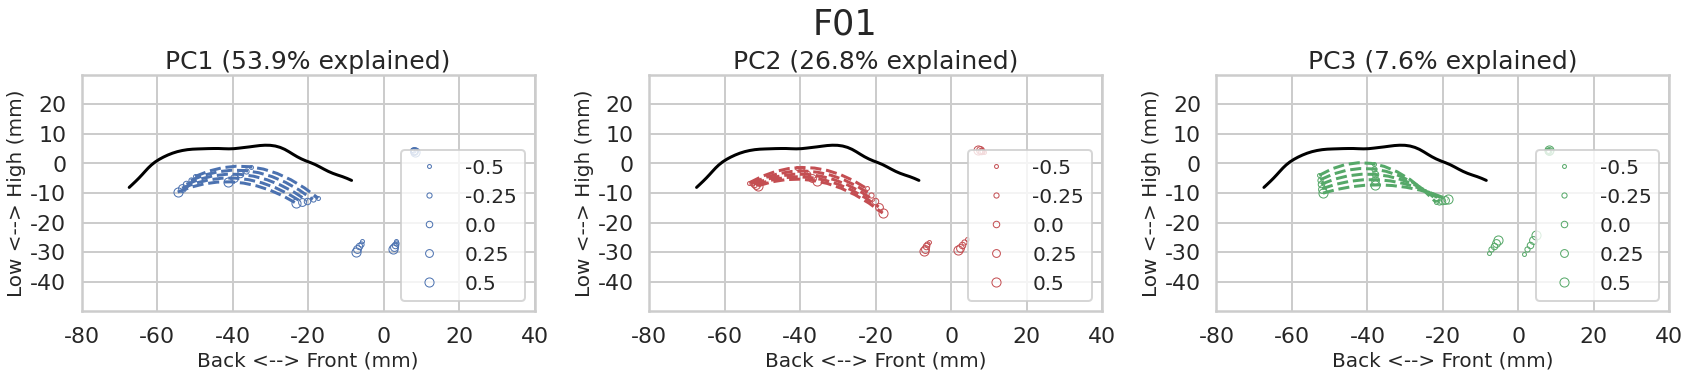

In [13]:
def func(which_spkr):
    return Image(filename=os.path.join(data_plot_dir, which_spkr, f'{which_spkr}_pca_gradient.png'), width=1000)

spkr_dropdown = widgets.Dropdown(options=spkr_list, value='F01')
interact(func, which_spkr=spkr_dropdown);
func('F01')

### PCA loading plot

Saved


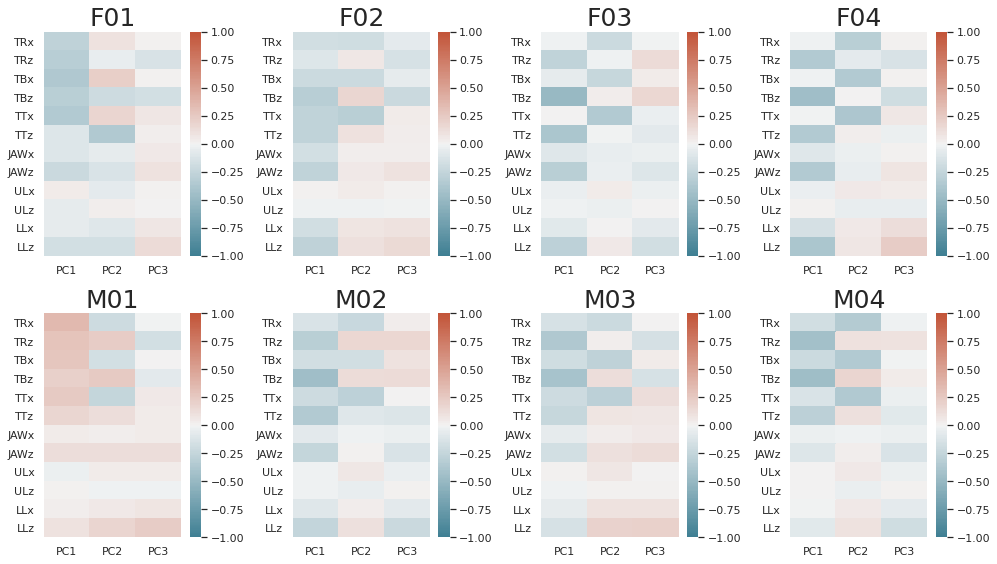

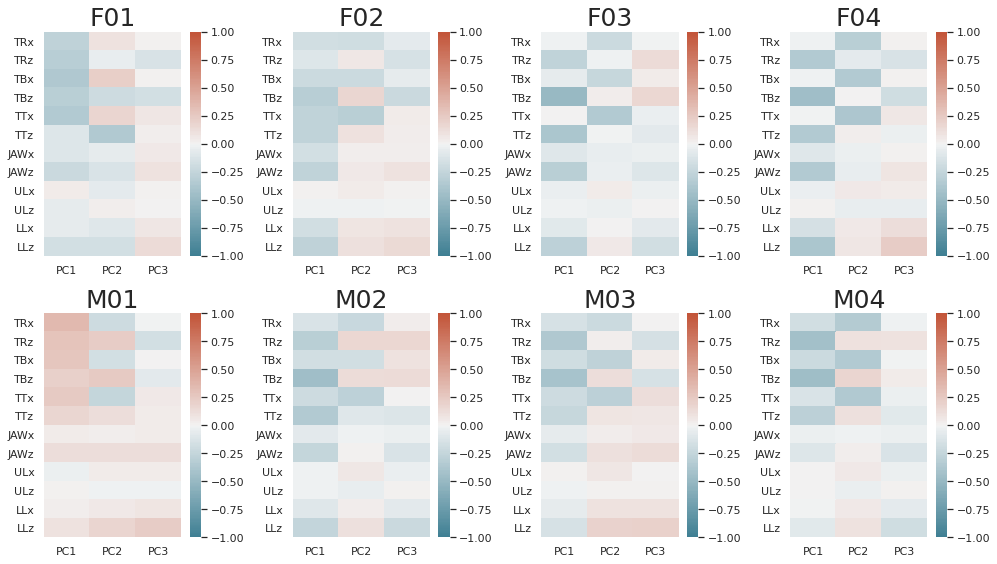

In [14]:
if plot_again:
    fig, arr = plt.subplots(2, 4, facecolor='white', figsize=(14, 8))
    for which_spkr, ax in zip(spkr_list, arr.flatten()):
        loadings = pd.DataFrame(PC[which_spkr]['pca'].components_.T * np.sqrt(PC[which_spkr]['pca'].explained_variance_),
                                columns=['PC1', 'PC2', 'PC3'],
                                index=artic_col)
        sns.heatmap(
            loadings,
            ax=ax,
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            #square=True
        )
        ax.set_title(which_spkr, fontsize=25)
    fig.tight_layout()
    fig.savefig(os.path.join(data_plot_dir, 'pca_loading_correlation.png'), bbox_inches='tight')
    print('Saved')

Image(filename=os.path.join(data_plot_dir, 'pca_loading_correlation.png'), width=1000)

## PCA pairwise plot

In [15]:
import io
import PIL

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = PIL.Image.open(buf)
    return img

def _pairplot(df, var_list, rate_colors, npc, pca_lim, title_txt, ucm_space=None):
    g = sns.PairGrid(df, x_vars=var_list, y_vars=var_list,
                     hue='Rate', 
                     palette=rate_colors, corner=True)
    g = g.map_lower(sns.scatterplot, s=15, hue_order=rate_list)
    g = g.map_diag(sns.kdeplot, hue_order=rate_list, common_norm=False)
    g = g.add_legend()
    g.fig.set_size_inches(7,7)
    g.fig.set_facecolor('white')
    g._legend.set_bbox_to_anchor((0.8, 0.8))
    # Iterate over axes
    for i in range(npc): # row
        for j in range(npc): # column
            # Draw bounding box
            if (g.axes[i,j] is not None):
                for _, spine in g.axes[i,j].spines.items():
                    spine.set_visible(True)
                    spine.set_color('gray')
            if (i != j) & (g.axes[i,j] is not None):
                # Set axis
                g.axes[i,j].set_xlim(pca_lim)
                g.axes[i,j].set_ylim(pca_lim)
                # Add UCM
                if ucm_space is not None:
                    g.axes[i,j].plot(ucm_space[:,j], ucm_space[:,i], '-', lw=1, color='blue', alpha=0.5)
            # fix diag xlim, ylim
            if (i==j):
                g.axes[i,j].set_xlim(pca_lim)
                g.axes[i,j].set_xlabel('')
    g.fig.suptitle(title_txt, fontsize=25, y=1.07)
    return g

In [7]:
def _load_model_params(which_spkr):
    # Prepare palate
    pal = pal_all[which_spkr]

    # Initiate
    scaler = Scaler(which_spkr, Z)
    pca = PC[which_spkr]['pca']
    return pal, scaler, pca


def _prep_data_for_ucm(which_spkr, which_vowel, which_rate, which_time, lim=[-0.5,0.5], nsample=5):
    # Prepare params
    pal, scaler, pca = _load_model_params(which_spkr)

    # Prepare original data
    if which_rate == 'NF':
        which_rate = ['N', 'F']
    else:
        which_rate = [which_rate]
    cond = ((D.Speaker==which_spkr)&
            (D.Vowel==which_vowel)&
            (D.TimeAt==which_time)&
            (D.Rate.isin(which_rate)))
    formants = D.loc[cond, acous_col].values
    artics = D.loc[cond, artic_col].values
    artics = scaler.transform(artics, 'artic')
    artics = pca.transform(artics).squeeze()
    
    median = (VT.loc[(VT.Speaker==which_spkr)&(VT.Vowel.isin(vowel_list))&(VT.TimeAt==which_time)]
              .sort_values(by='Vowel', key=lambda col: [vowel_list.index(v) for v in col.values])[acous_col]
              .values) # acous median

    # Get vowel-median artic data 
    #vdata = VT.loc[(VT.Speaker==which_spkr)&(VT.Vowel==which_vowel), artic_col].values
    vdata = D.loc[cond, artic_col].median(axis=0).values[np.newaxis,:]
    vdata = scaler.transform(vdata, 'artic')
    vdata = pca.transform(vdata).squeeze()
    init_pcs = vdata

    return init_pcs, median, pal, scaler, pca, artics, formants

### Visualize data onto PC space

In [17]:
which_time = 0.5
# which_model = 'all'
suffix = 'pca_space'
lim = [-20, 20]  # synthesis range
pca_lim = [-2.5,2.5]
nsample = 5
npc = 3
rate_colors = sns.color_palette('tab10', len(rate_list))

if plot_again:
    for which_spkr in tqdm(spkr_list, total=len(spkr_list)):
    #for which_spkr in tqdm(['F01'], total=1):
        for which_vowel in vowel_list:
            # For NF together
            init_pcs, median, pal, scaler, pca, artics, formants = _prep_data_for_ucm(
                which_spkr, which_vowel, 'NF', which_time,  # conditions
                lim=lim, nsample=nsample)
            # For N rate
            _, _, _, _, _, artics_N, formants_N = _prep_data_for_ucm(
                which_spkr, which_vowel, 'N', which_time,  # conditions
                lim=lim, nsample=nsample)
            # For F rate
            _, _, _, _, _, artics_F, formants_F = _prep_data_for_ucm(
                which_spkr, which_vowel, 'F', which_time,  # conditions
                lim=lim, nsample=nsample)

            # Make sure to center artics by substracting init_pcs
            artics_raw = np.vstack([artics_F, artics_N])
            artics_centered = artics_raw - init_pcs

            NF = pd.DataFrame({
                'PC1': artics_raw[:,0],
                'PC2': artics_raw[:,1],
                'PC3': artics_raw[:,2],
            })
            NF['Speaker'] = which_spkr
            NF['Vowel'] = which_vowel
            NF['Rate'] = ['F']*(artics_F.shape[0]) + ['N']*(artics_N.shape[0]) # this changed plotting zorder!!

            # Plot
            sns.set_theme(context='paper', style='whitegrid', 
                          rc={'legend.fontsize': 20, 
                              'legend.title_fontsize': 20,
                              'axes.labelsize': 20})
            # ----- Original data
            h = _pairplot(NF, ['PC1','PC2','PC3'], rate_colors, npc, pca_lim, 'Data', ucm_space=None)

            # Combine
            img1 = fig2img(h)
            max_width = img1.size[0] * 3
            max_height = img1.size[1]
            new_img = PIL.Image.new('RGB', (max_width, max_height))
            x_offset = 0
            new_img.paste(img1, (0,0))
            new_img.save(os.path.join(data_plot_dir, which_spkr, f'{which_spkr}_{which_vowel}_{suffix}.png'))

            # clean up
            img1.close()
            new_img.close()
            plt.close('all')
    print('Saved') # ~ 10 min
else:
    print('Skipping')

100%|██████████| 8/8 [01:13<00:00,  9.21s/it]

Saved


In [ ]:
def func3(which_spkr, which_vowel):
    return Image(filename=os.path.join(data_plot_dir, which_spkr, f'{which_spkr}_{which_vowel}_{suffix}.png'), width=1000)

spkr_dropdown3 = widgets.Dropdown(options=spkr_list, value='F01')
vowel_dropdown3 = widgets.Dropdown(options=vowel_list, value='IY1')
interact(func3, which_spkr=spkr_dropdown3, which_vowel=vowel_dropdown3);
func3('F01', 'IY1')

---

## Guided PCA
- Do Guided PCA analysis
- Visualize PCs

In [125]:
factor_matrix = np.array([
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],  # factor1: JAWx, JAWy
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],  # factor2: ULx,ULy,LLx,LLy
    [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],  # factor3: T1y,T2y,T3y
    [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # factor4: T1x,T2x,T3x
#     [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # factor4: T1x,T2x,T3x
#     [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],  # factor3: T1y,T2y,T3y
])

### Do Guided PCA analysis

In [126]:
# Save
if save_again:
    which_rate = 'N'
    which_time = 0.5
    GPC = {}
    for i in tqdm(range(len(spkr_list))):
        spkr = spkr_list[i]
        data = D.loc[(D.Speaker==spkr)&(D.TimeAt==which_time)&(D.Rate==which_rate), artic_col].values
        scaler = Scaler(spkr, Z)
        zdata = scaler.transform(data, 'artic')

        # Guided PCA
        gpca = GuidedPCA(factor_matrix, n_components=num_gpca)
        gpca.fit(zdata)
        GPC.update({
            spkr: {
                'gpca': gpca,
                'components': gpca.components_,
                'explained_variance_ratio_': gpca.explained_variance_ratio_.tolist(),
                #'singular_values_': gpca.singular_values_.tolist(),
                'info': f'guided pca, extracted {get_date()}'}})

    # Save
    with open(os.path.join(gpca_file), 'wb') as pckl:
        pickle.dump(GPC, pckl)
    print(os.path.join(gpca_file), 'Saved')
else:
    # If parameters are saved before, just load it!
    with open(os.path.join(gpca_file), 'rb') as pckl:
        GPC = pickle.load(pckl)
    print(os.path.join(gpca_file), 'Loaded')

100%|██████████| 8/8 [00:00<00:00, 53.10it/s]

data_processed/gpca.pkl Saved


- amount variability explained

In [127]:
# Check variance explained
avg = 0
for which_spkr in spkr_list:
    ratios = GPC[which_spkr]['explained_variance_ratio_']
    #ratios_perc = [f'{r*100:.0f} %' for r in ratios]
    avg += ratios
    print(f'{which_spkr}: {ratios*100:.0f}%')
print(f'==> Average: {avg/len(spkr_list)*100:.2f} %')

F01: 82%
F02: 83%
F03: 87%
F04: 92%
M01: 84%
M02: 83%
M03: 87%
M04: 92%
==> Average: 86.30 %


### Visualize Guided PCs

- Move only each component and reconstruct

In [128]:
def _validate_gpca_by_reconstruction(df, which_spkr, which_rate, which_vowel, which_time, artic_col, artic_col_norm, GPC, Z):
    gpca = GPC[which_spkr]['gpca']
    scaler = Scaler(which_spkr, Z)
    d = df.loc[(df.Speaker == which_spkr) & (df.Rate == which_rate) & (
        df.Vowel == which_vowel) & (df.TimeAt == which_time), artic_col]
    dn = df.loc[(df.Speaker == which_spkr) & (df.Rate == which_rate) & (
        df.Vowel == which_vowel) & (df.TimeAt == which_time), artic_col_norm]

    sns.set_theme(context='paper')
    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3, figsize=(18, 5), facecolor='white')

    # Original data
    plot_palpha(ax1, pal_all[which_spkr], pha=None)
    plot_artic_df(ax1, d, ['TRx', 'TBx', 'TTx'], ['TRz', 'TBz', 'TTz'], ['JAWx'], [
                  'JAWz'], ['ULx', 'LLx'], ['ULz', 'LLz'], tongue_spline=True)
    ax1.set_title('Original', fontsize=25)

    # Normalized data
    plot_artic_df(ax2, dn, ['TRx_norm', 'TBx_norm', 'TTx_norm'],
                  ['TRz_norm', 'TBz_norm', 'TTz_norm'],
                  ['JAWx_norm'], ['JAWz_norm'],
                  ['ULx_norm', 'LLx_norm'], ['ULz_norm', 'LLz_norm'], tongue_spline=True)
    ax2.set_xlim([-2, 2])
    ax2.set_ylim([-2, 2])
    ax2.set_title('Normalized', fontsize=25)

    # Reconstructed data
    dz = dn.values
    dz = gpca.transform(dz)
    dz = gpca.inverse_transform(dz)
    dz = scaler.inverse_transform(dz, 'artic')
    dnz = dn.copy()
    dnz[artic_col] = dz
    plot_palpha(ax3, pal_all[which_spkr], pha=None)
    plot_artic_df(ax3, dnz, ['TRx', 'TBx', 'TTx'], ['TRz', 'TBz', 'TTz'], [
                  'JAWx'], ['JAWz'], ['ULx', 'LLx'], ['ULz', 'LLz'], tongue_spline=True)
    ax3.set_title('Reconstructed', fontsize=25)
    plt.suptitle(f'{which_spkr}, {which_vowel}', fontsize=30, y=1.05)
    return fig, (ax1, ax2, ax3)

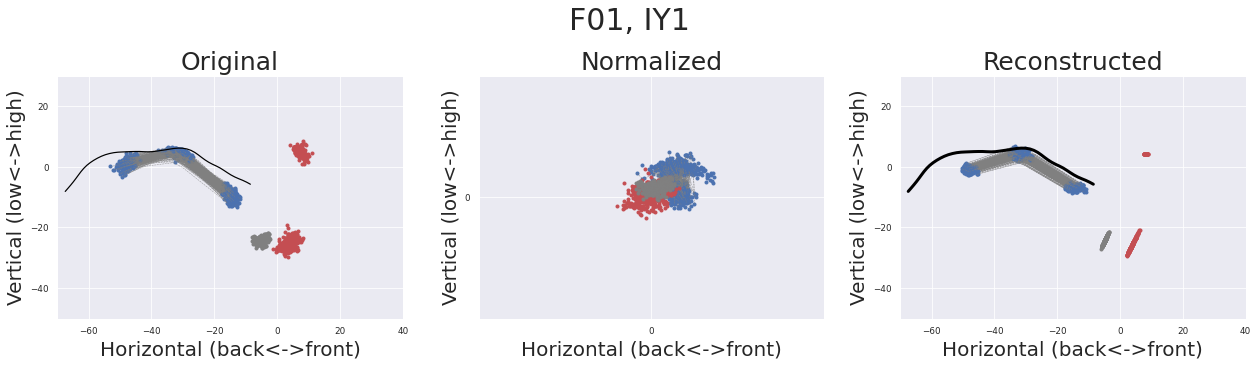

In [129]:
which_spkr = 'F01'
which_vowel = 'IY1'
which_rate = 'N'
which_time = 0.5

with sns.plotting_context(context='paper'):
    fig, arr = _validate_gpca_by_reconstruction(D, which_spkr, which_rate, which_vowel, which_time, artic_col, artic_col_norm, GPC, Z)

### Add GPC columns to data

In [130]:
D[gpca_col] = 0

for which_spkr in spkr_list:
    condition = (D.Speaker==which_spkr)
    scaler = Scaler(which_spkr, Z)
    gpca = GPC[which_spkr]['gpca']
    
    d = D.loc[condition, artic_col].values
    d = scaler.transform(d, 'artic')
    d = gpca.transform(d)
    D.loc[condition, gpca_col] = d
print('Done')

Done


### Gradient Plot (Guided PCA)

In [131]:
gpca_col

['JAW', 'LIPS', 'vTNG', 'hTNG']

In [132]:
# Prepare data
lim = [-0.5, 0.5] # synthesis range
npc = len(gpca_col)
nsample = 5
samples = np.linspace(lim[0], lim[1], nsample)
data = np.zeros((nsample*npc, npc))
data[nsample*0:nsample*1,0] = samples
data[nsample*1:nsample*2,1] = samples
data[nsample*2:nsample*3,2] = samples
data[nsample*3:nsample*4,3] = samples

Speaker = []
PC_col = []
SD_col = []
artic_data = np.zeros((len(spkr_list)*npc*nsample, len(artic_col)))

# Iterate over speakers
for i, which_spkr in tqdm(enumerate(spkr_list), total=len(spkr_list)):
    scaler = Scaler(which_spkr, Z)
    gpca = GPC[which_spkr]['gpca']
    pal = pal_all[which_spkr]
    xdata = gpca.inverse_transform(data)
    xdata = scaler.inverse_transform(xdata, 'artic')
    
    Speaker += [which_spkr]*npc*nsample
    PC_col += sorted(gpca_col*nsample)
    SD_col += samples.tolist()*npc
    artic_data[npc*nsample*i:npc*nsample*(i+1),:] = xdata

PD = pd.DataFrame({
    'Speaker':Speaker,
    'PCA':PC_col,
    'SD':SD_col,
})
PD[artic_col] = pd.DataFrame(artic_data)
PD.head()

100%|██████████| 8/8 [00:00<00:00, 11711.84it/s]


,Speaker,PCA,SD,TRx,TRz,TBx,TBz,TTx,TTz,JAWx,JAWz,ULx,ULz,LLx,LLz
0,F01,JAW,-0.50,-52.261519,-7.061744,-38.107728,-3.715249,-20.227938,-12.643488,-3.837297,-21.994167,7.932878,4.24144,2.950789,-27.519125
1,F01,JAW,-0.25,-52.261519,-7.061744,-38.107728,-3.715249,-20.227938,-12.643488,-5.181408,-25.010809,7.932878,4.24144,2.950789,-27.519125
2,F01,JAW,0.00,-52.261519,-7.061744,-38.107728,-3.715249,-20.227938,-12.643488,-6.525520,-28.027450,7.932878,4.24144,2.950789,-27.519125
3,F01,JAW,0.25,-52.261519,-7.061744,-38.107728,-3.715249,-20.227938,-12.643488,-7.869631,-31.044092,7.932878,4.24144,2.950789,-27.519125
4,F01,JAW,0.50,-52.261519,-7.061744,-38.107728,-3.715249,-20.227938,-12.643488,-9.213743,-34.060734,7.932878,4.24144,2.950789,-27.519125


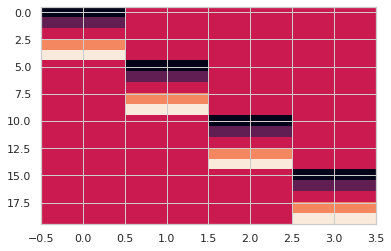

In [133]:
plt.imshow(data, aspect='auto')

100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Saved


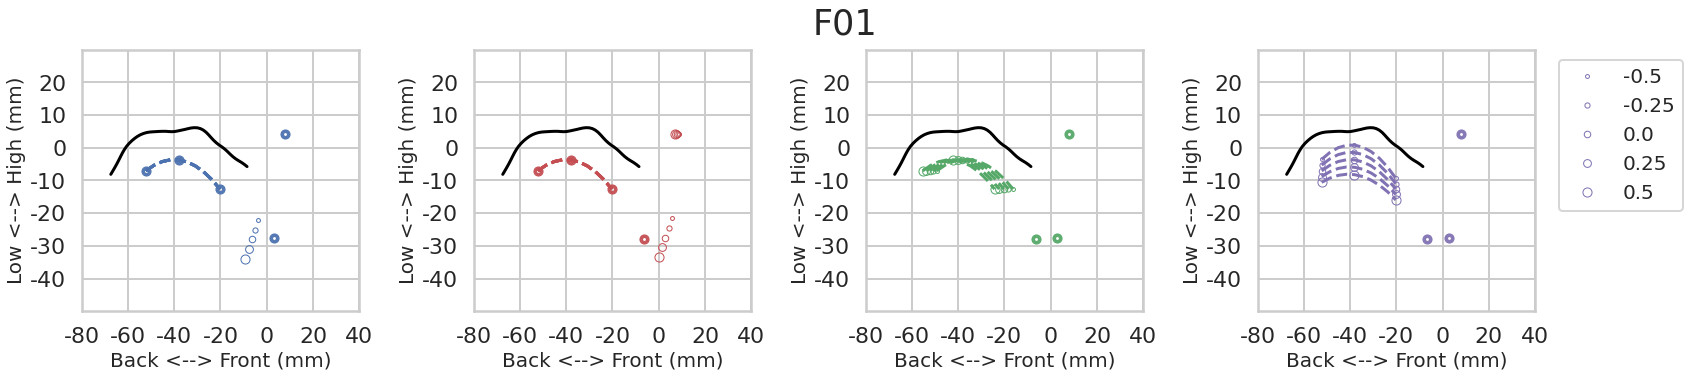

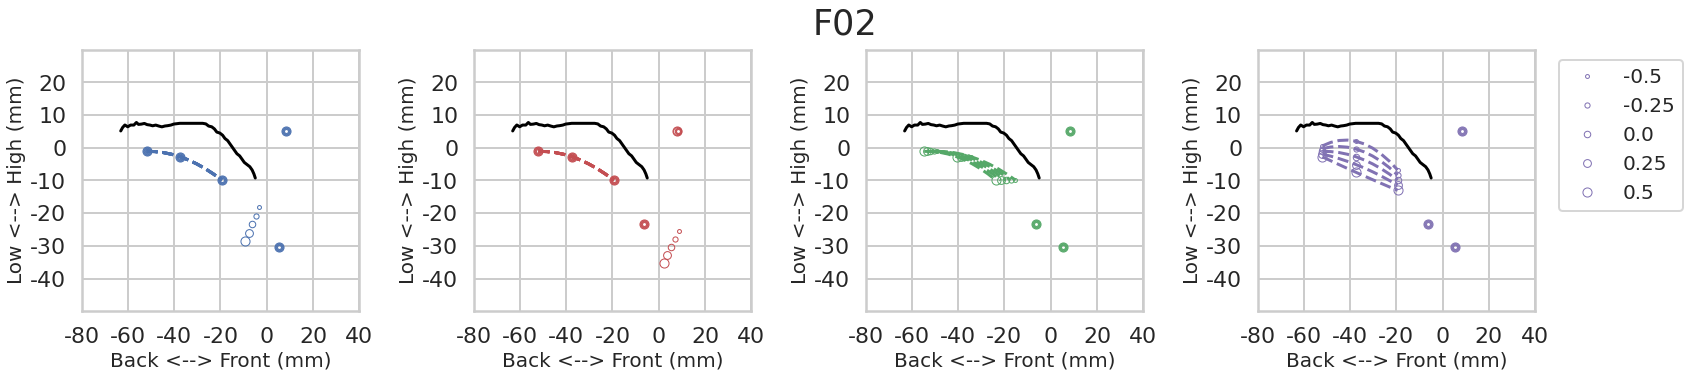

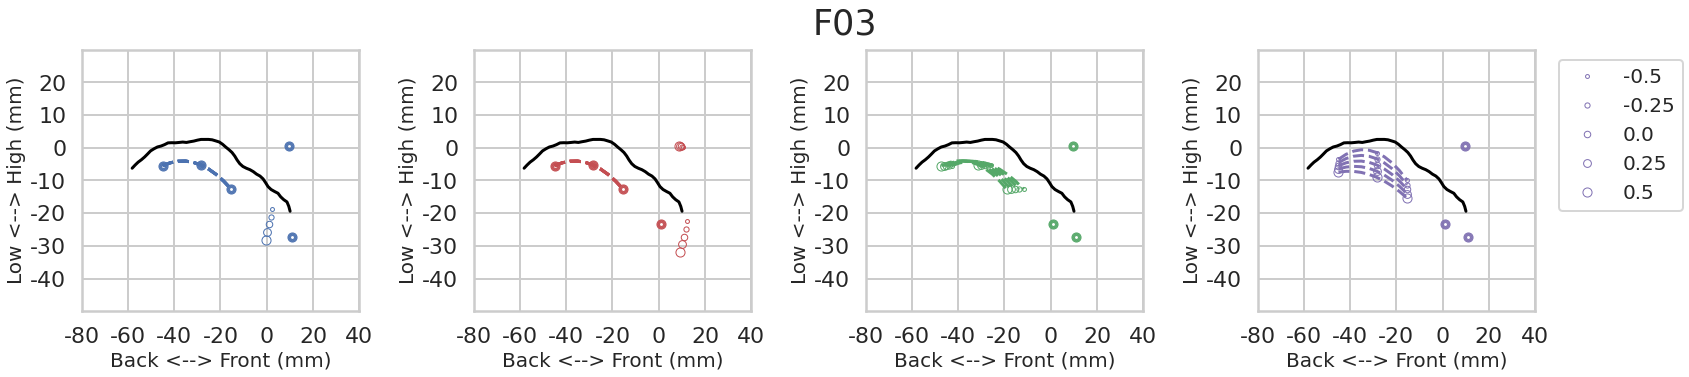

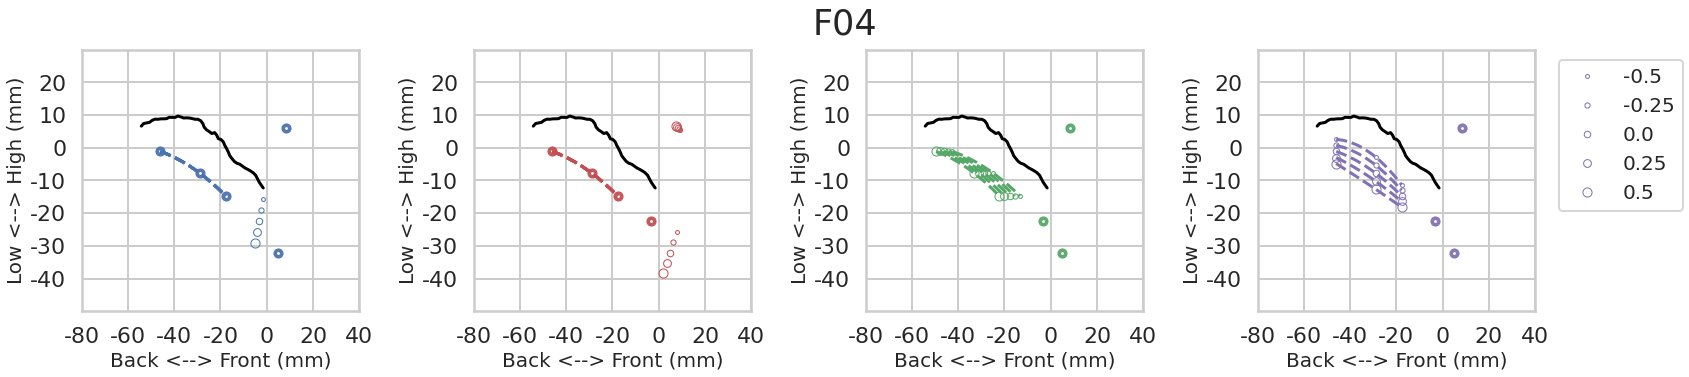

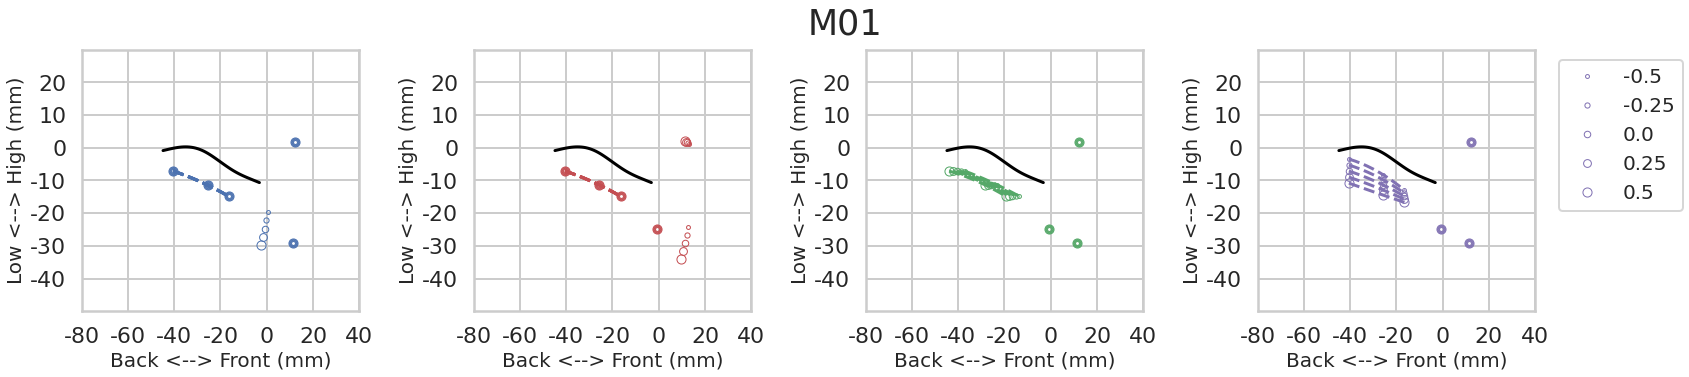

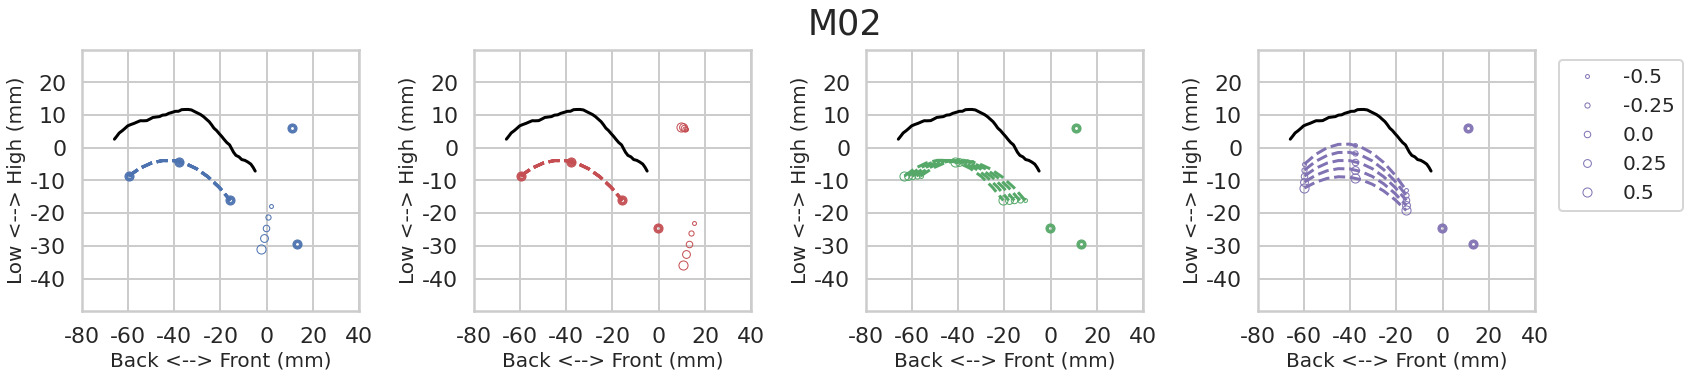

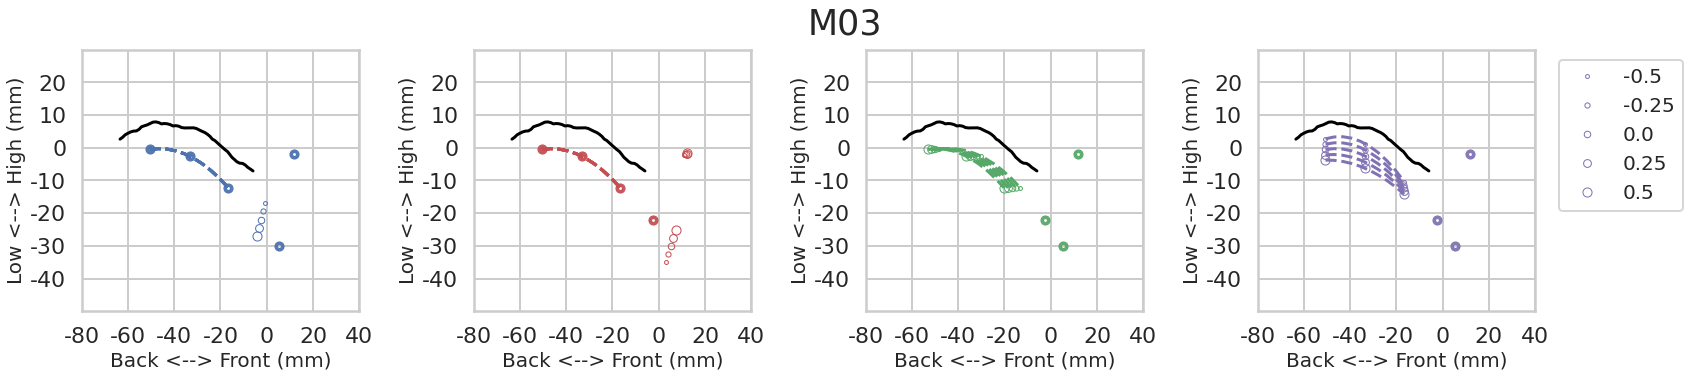

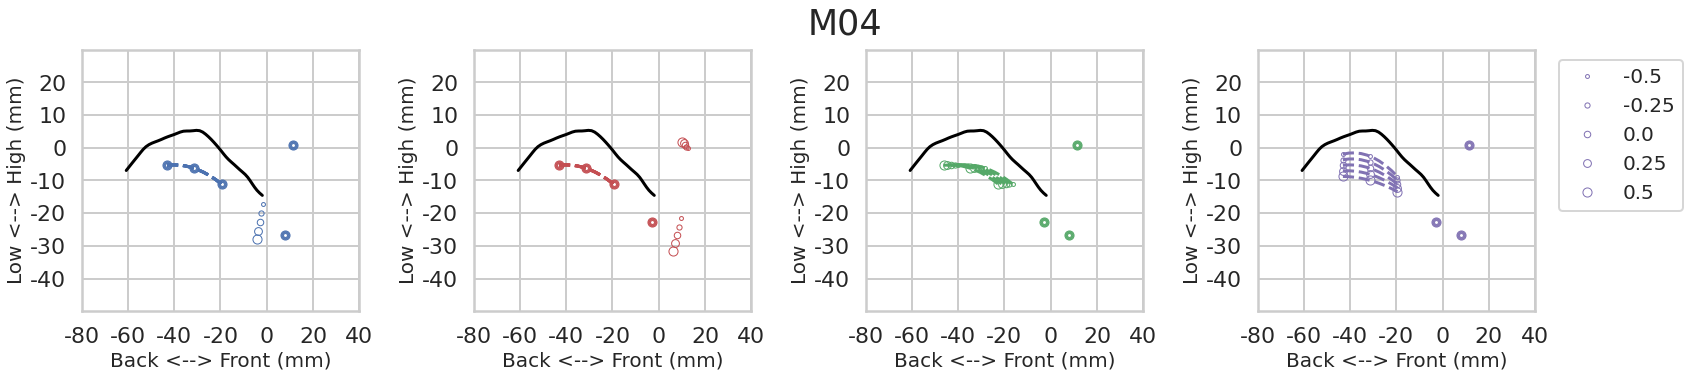

In [134]:
marker_types = ['circle', 'triangle_up', 'diamond']
colors = ['b', 'r', 'g', 'm']
ytick_lim = [-40, 20]
xtick_lim = [-80, 40]

# Visualize
if plot_again:
    sns.set_theme(style="whitegrid", rc={'font.family' : 'serif' , 'font.serif' : 'Times New Roman'})
    with sns.plotting_context(context='poster', font_scale=1):
        # Iterate over speakers
        for which_spkr in tqdm(spkr_list, total=len(spkr_list)):
            explained = GPC[which_spkr]['explained_variance_ratio_']
            fig, arr = plt.subplots(1, 4, facecolor='white', figsize=(24, 6))
            # Iterate over PCs
            for i, (ax, which_pc) in enumerate(zip(arr, gpca_col)):
                ax = plot_palpha(ax, pal=pal_all[which_spkr], fontsize=20)
                lines = []
                # Iterate over SD
                for j, which_sd in enumerate(samples):
                    # Plot
                    ax = plot_artic(ax,
                                    PD.loc[(PD.Speaker == which_spkr) & (PD.PCA == which_pc) & (PD.SD == which_sd),
                                           artic_col].values,
                                    tongue_idx=[0, 1, 2, 3, 4, 5], jaw_idx=[6, 7], lip_idx=[8, 9, 10, 11],
                                    tongue_spline=True, markersize=(j+3)*1.3,
                                    override_color=[colors[i]]*3,
                                    markerfacecolor='none')
                    lines += [ax.get_lines()[-1]]
                # Add legend only at the final plot
                if i == len(gpca_col) - 1:
                    ax.legend(lines, samples, fontsize='small', bbox_to_anchor=(1.05, 1))
                # Prettify
                #ax.set_title(f'{which_pc} ({explained[i]*100:.1f}% explained)', fontsize=25)
                xticks = np.linspace(xtick_lim[0], xtick_lim[1], 7)
                ax.set_xticks([t for t in xticks])
                ax.set_xticklabels([f'{t:.0f}' for t in xticks])
                yticks = np.linspace(ytick_lim[0], ytick_lim[1], 7)
                ax.set_yticks([t for t in yticks])
                ax.set_yticklabels([f'{t:.0f}' for t in yticks])
            fig.suptitle(f'{which_spkr}', fontsize=35, y=0.9)
            fig.tight_layout()
            
            fig.savefig(os.path.join(data_plot_dir, which_spkr, f'{which_spkr}_gpca_gradient.png'), bbox_inches='tight')
            #plt.close()
    print('Saved')
else:
    print('Skipping')

# 여서부터 다시!! 왜 PC3과 PC4가 반대로 나오는지 확인할 것!!!